# **Control for elementary Reinforcement Learning problems**

Objectives: understanting the concept of control in RL for a simple grid-world environment and implement the Q-Learning algorithm

1.   Train Q-Learning on one of the custom environments implemented (`GridWorldBlindEnemyEnv` and/or `GridWorldOracleEnemyEnv`)
2.   Perform analysis regarding hyper-parameters of the algorithm



Install needed Python packages

In [ ]:
!pip install pygame gym numpy

Import needed Python packages

In [ ]:
import gym
from gym import spaces
import pygame
import numpy as np

Mount Google Drive for saving results (not needed if running the notebook locally)

In [ ]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"         # default location for the drive

drive.mount(ROOT)              # we mount the google drive at /content/drive

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/drive


Imports and functions for recording/showing videos

In [ ]:
from gym.wrappers import RecordVideo
from pathlib import Path
import base64
from IPython import display as ipythondisplay

In [ ]:
# Set up fake display; otherwise rendering will fail on Google Colab
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [ ]:
def show_videos(video_path='', prefix=''):
  html = []
  for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
      video_b64 = base64.b64encode(mp4.read_bytes())
      html.append('''<video alt="{}" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>'''.format(mp4, video_b64.decode('ascii')))
  ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

Record video of ten steps for random policy on `GridEnv` environment

In [ ]:
import sys
import os

is_colab = 'google.colab' in sys.modules
root_dir ='drive/MyDrive/WinterSchoolRL2024' if is_colab else '.'
video_folder = os.path.join(root_dir, 'Videos')
os.makedirs(video_folder, exist_ok=True)

# **Q-Learning**

## Q-Learning on `GridWorldEnv`

In [ ]:
class GridWorldEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, render_mode=None, size=5):
        self.size = size  # The size of the square grid
        self.window_size = 512  # The size of the PyGame window

        # Observations are dictionaries with the agent's and the target's location.
        # Each location is encoded as an element of {0, ..., `size`}^2, i.e. MultiDiscrete([size, size]).
        self.observation_space = spaces.Dict(
            {
                "agent": spaces.Box(0, size - 1, shape=(2,), dtype=int),
                "target": spaces.Box(0, size - 1, shape=(2,), dtype=int),
            }
        )

        # We have 4 actions, corresponding to "right", "up", "left", "down"
        self.action_space = spaces.Discrete(4)

        """
        The following dictionary maps abstract actions from `self.action_space` to
        the direction we will walk in if that action is taken.
        I.e. 0 corresponds to "right", 1 to "up" etc.
        """
        self._action_to_direction = {
            0: np.array([1, 0]),
            1: np.array([0, 1]),
            2: np.array([-1, 0]),
            3: np.array([0, -1]),
        }

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        """
        If human-rendering is used, `self.window` will be a reference
        to the window that we draw to. `self.clock` will be a clock that is used
        to ensure that the environment is rendered at the correct framerate in
        human-mode. They will remain `None` until human-mode is used for the
        first time.
        """
        self.window = None
        self.clock = None

    # Private method to get observations
    def _get_obs(self):
        return {"agent": self._agent_location, "target": self._target_location}

    # Private method to get info
    def _get_info(self):
        return {"distance": np.linalg.norm(self._agent_location - self._target_location, ord=1)}

    # Reset method for the environment
    def reset(self, seed=None, options=None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)

        # Choose the agent's location uniformly at random
        self._agent_location = self.np_random.integers(0, self.size, size=2, dtype=int)

        # We will sample the target's location randomly until it does not coincide with the agent's location
        self._target_location = self._agent_location
        while np.array_equal(self._target_location, self._agent_location):
            self._target_location = self.np_random.integers(
                0, self.size, size=2, dtype=int
            )

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, info

    # Step method for the environment
    def step(self, action):
        # Map the action (element of {0,1,2,3}) to the direction we walk in
        direction = self._action_to_direction[action]
        # We use `np.clip` to make sure we don't leave the grid
        self._agent_location = np.clip(
            self._agent_location + direction, 0, self.size - 1
        )
        # An episode is done iff the agent has reached the target
        terminated = np.array_equal(self._agent_location, self._target_location)
        reward = 1 if terminated else 0  # Binary sparse rewards
        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, reward, terminated, False, info

    # Render method for visualization
    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

    def _render_frame(self):
        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode((self.window_size, self.window_size))
        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, self.window_size))
        canvas.fill((255, 255, 255))
        pix_square_size = (
            self.window_size / self.size
        )  # The size of a single grid square in pixels

        # First we draw the target
        pygame.draw.rect(
            canvas,
            (255, 0, 0),
            pygame.Rect(
                pix_square_size * self._target_location,
                (pix_square_size, pix_square_size),
            ),
        )
        # Now we draw the agent
        pygame.draw.circle(
            canvas,
            (0, 0, 255),
            (self._agent_location + 0.5) * pix_square_size,
            pix_square_size / 3,
        )

        # Finally, add some gridlines
        for x in range(self.size + 1):
            pygame.draw.line(
                canvas,
                0,
                (0, pix_square_size * x),
                (self.window_size, pix_square_size * x),
                width=3,
            )
            pygame.draw.line(
                canvas,
                0,
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_size),
                width=3,
            )

        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )


Initialize grid-world environment

In [ ]:
grid_size = 5
gwenv = GridWorldEnv(render_mode='rgb_array', size=grid_size)

Function to inizialize the Q table

In [ ]:
def initializeQ(gwenv):
  Q = np.zeros((gwenv.size, gwenv.size,   # x and y for agent
                gwenv.size, gwenv.size,   # x and y for target
                gwenv.action_space.n))    # actions
  return Q


Function to run one episode of the algorithm on `GridWorldEnv`

In [ ]:
def run_episode_gwenv(env, Q, lr, discount, epsilon=0.1, render=False, _maxsteps=20, optimal=False):

	observation, _ = env.reset()
	done = False
	nsteps = 0

	for x in range(_maxsteps):

		nsteps += 1

		if done:
			break

		if render:
			env.render()

		curr_state = observation

		# handle multi dims of Q table
		ax = curr_state['agent'][0]
		ay = curr_state['agent'][1]
		tx = curr_state['target'][0]
		ty = curr_state['target'][1]

		# training time
		if not optimal:

			# Epsilon-greedy policy
			randnum = np.random.rand(1)
			if randnum < epsilon:
				action = env.action_space.sample()
			else:
				action = np.argmax(Q[ax, ay, tx, ty,:])

			observation, reward, done, _, info = env.step(action)

			# handle multi-dims of Q table
			ax_next = observation['agent'][0]
			ay_next = observation['agent'][1]
			tx_next = observation['target'][0]
			ty_next = observation['target'][1]

			#Q(state, action) = R(state, action) + Gamma * Max[Q(next state, all actions)]
			Q[ax, ay, tx, ty, action] += lr * (reward+ discount*np.max(Q[ax_next, ay_next, tx_next, ty_next, :]) - Q[ax, ay, tx, ty, action])

		# evaluation time
		else:
			action = np.argmax(Q[ax, ay, tx, ty,:])

			observation, reward, done, _, info = env.step(action)

	return Q, reward


Function to run Q-Learning

In [ ]:
from pyparsing.helpers import Callable
from tqdm import tqdm

def QLearning(env: gym.Env, num_episodes: int, initQ: Callable, run_episode: Callable, config: dict):

	reward_per_ep = list()
	Q = initQ(env)

	for i in tqdm(range(num_episodes)):
		Q, reward = run_episode(env, Q, **config)
		reward_per_ep.append(reward)

	return Q, reward_per_ep



Train Q-Learning on `GridWorldEnv`

In [ ]:
config = {}
config['lr'] = 0.1
config['discount'] = 0.99
config['epsilon'] = 0.2
num_episodes = 10000

Q_trained, reward_per_ep = QLearning(gwenv,
                                  	num_episodes,
																		initQ=initializeQ,
																		run_episode=run_episode_gwenv,
																		config=config)

100%|██████████| 10000/10000 [00:05<00:00, 1959.52it/s]


Plot learning curve (i.e., average reward over fixed window)

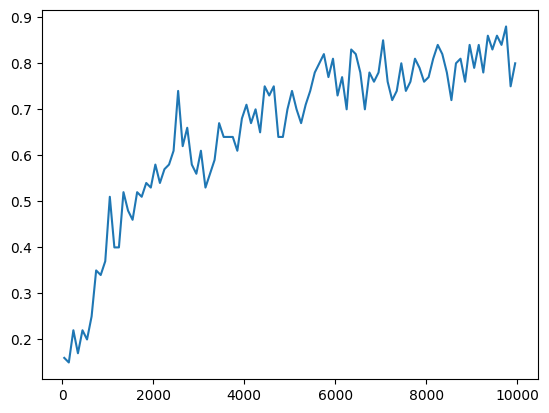

In [ ]:
from matplotlib import pyplot as plt

def averagewindow(R, d=1):
    n = len(R)
    t = []
    y = []
    for i in range(0,int(n/d)):
        t.append(np.mean(range(i*d,(i+1)*d)));
        y.append(np.mean(R[i*d:min(n,(i+1)*d)]))
    return t,y

window = 100
t,y = averagewindow(reward_per_ep, d=window)
plt.plot(t, y)

Record video in inference mode

In [ ]:
config['optimal'] = True                  # no learning anymore
config['render'] = True                   # render for recording
initQ_trained = lambda env: Q_trained     # dummy function that returns the trained Q table
prefix = 'gwenv_q'
vid_episodes = 3

# use wrapper to record videos
gwenv_vid = RecordVideo(gwenv,
                        video_folder=video_folder,
                        episode_trigger=lambda ep: (ep < vid_episodes),
                        step_trigger=None,
                        video_length=0,
                        name_prefix=prefix,
                        new_step_api=True
                        )

# use wrapper to record videos
Q_trained, reward_per_ep_test = QLearning(gwenv_vid,
                                          num_episodes=vid_episodes,
                                          initQ=initQ_trained,
                                          run_episode=run_episode_gwenv,
                                          config=config)

/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive/WinterSchoolRL2024/Videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
100%|██████████| 3/3 [00:00<00:00,  3.23it/s]


Play videos over some episodes

In [ ]:
show_videos(video_folder, prefix=prefix)

## Q-Learning on `GridWorldBlindEnemyEnv` and/or `GridWorldOracleEnemyEnv`

The task is to train our virtual agent with Q-Learning on one of the two custom environments previously created.
Analyze the results concerning different hyper-parameters of the algorithm (e.g., impact of learning rate, discount factor, etc.).

Note:
- The Q-table should be initialized in a different way since the state now should contain additional information (e.g., the position of the enemy)
- The Q-learning loop should be updated to handle the changes applied to the Q-table


In [ ]:
# TO COMPLETE

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
